In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torchvision.models.detection as detection
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import sklearn.metrics
from torchvision.ops import box_iou

# **Downloading the Dataset from Roboflow**

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mgyYYQWIMNNPZFKv4VfJ")
project = rf.workspace("computer-vision-6p7fp").project("aircraft-object-detection")
version = project.version(7)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


### *Splitting the Dataset into Training, Validation, and Testing Sub-datasets (60%, 20%, 20% respectively)*

In [3]:
dataset_path = dataset.location
train_dataset_path = os.path.join(dataset_path, 'train')
val_dataset_path = os.path.join(dataset_path, 'valid')
test_dataset_path = os.path.join(dataset_path, 'test')

train_annotations_path = os.path.join(train_dataset_path, '_annotations.coco.json')
val_annotations_path = os.path.join(val_dataset_path, '_annotations.coco.json')
test_annotations_path = os.path.join(test_dataset_path, '_annotations.coco.json')

In [4]:
print('Training:\n', train_dataset_path, '\n', train_annotations_path)
print('\nValidation:\n', val_dataset_path, '\n', val_annotations_path)
print('\nTesting:\n', test_dataset_path, '\n', test_annotations_path)

Training:
 /content/Aircraft-Object-Detection-7/train 
 /content/Aircraft-Object-Detection-7/train/_annotations.coco.json

Validation:
 /content/Aircraft-Object-Detection-7/valid 
 /content/Aircraft-Object-Detection-7/valid/_annotations.coco.json

Testing:
 /content/Aircraft-Object-Detection-7/test 
 /content/Aircraft-Object-Detection-7/test/_annotations.coco.json


In [5]:
# apply transformations: resizing image to 256 x 256, converting the image to tensor objects, and finally, normalizing it
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
    ])

def collate_fn(batch):
    images, targets_list = zip(*batch)
    images = torch.stack(images, 0)

    new_targets = []
    for targets in targets_list:
        # Initialize containers for the batched data
        batched_boxes = []
        batched_labels = []

        # Collect data from each target in the list of dictionaries
        for target in targets:
            box = torch.as_tensor(target['bbox'], dtype=torch.float32)
            # Convert COCO bbox from [top left x, top left y, width, height] to [xmin, ymin, xmax, ymax]
            box[2:] += box[:2]
            batched_boxes.append(box)
            batched_labels.append(target['category_id'])

        # Create a single new target dictionary for the current image
        new_target = {}
        new_target['boxes'] = torch.stack(batched_boxes)
        new_target['labels'] = torch.tensor(batched_labels)
        new_targets.append(new_target)

    return images, new_targets

# split dataset into training, validation, and testing
train_dataset = datasets.CocoDetection(root = train_dataset_path, annFile = train_annotations_path, transform = transform)
val_dataset = datasets.CocoDetection(root = val_dataset_path, annFile = val_annotations_path, transform = transform)
test_dataset = datasets.CocoDetection(root = test_dataset_path, annFile = test_annotations_path, transform = transform)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
torch.manual_seed(40)

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
validate_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)

In [7]:
train_dataset.coco.dataset['images'][0]              # contains information about the first image: id, license, file_name, height, width, and date_captured
train_dataset.coco.dataset['annotations'][0]
train_dataset.coco.dataset['categories']              # categories that can be returned --> either aircraft or background (none)
train_dataset.coco.dataset['annotations'][0]['bbox']  # bounding box coordinates of the first image in the training dataset

[72, 0, 36.431, 28.692]

### *Visualizing 10 Samples*

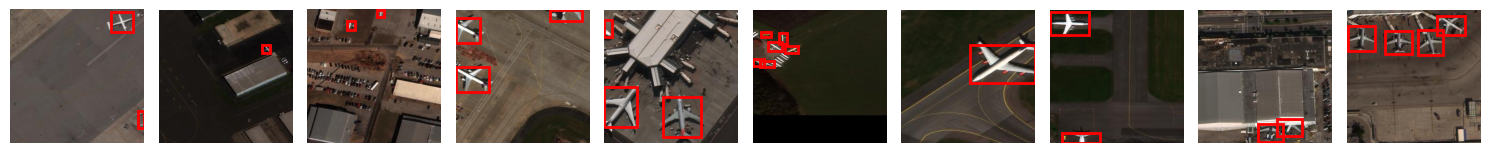

In [14]:
images, targets = next(iter(train_dataloader))
fig, axs = plt.subplots(1, 10, figsize = (15, 10))

for i in range(10):
    img = images[i].numpy().transpose(1, 2, 0)

    # normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    axs[i].imshow(img)
    axs[i].axis('off')

    boxes = targets[i]['boxes'].numpy()
    for box in boxes:
      rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
      axs[i].add_patch(rect)

plt.tight_layout()
plt.show()

# **RetinaNet Object Detection Model**

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
retinanet_model = detection.retinanet_resnet50_fpn(pretrained = True)
retinanet_model.to(device)
print(retinanet_model)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


## **Training the Network**

### *a. Training the Network (1 Epoch)*

In [50]:
optimizer = optim.Adam(retinanet_model.parameters(), lr = 0.001)

# train the neural network
retinanet_model.train()

noEpochs = 1

for epoch in range(noEpochs):
    training_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        images, targets = data
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # reset gradients
        optimizer.zero_grad()

        # forward pass
        loss_dict = retinanet_model(images, targets)  # here, the model computes the loss internally (Smooth L1 Loss Function)
        total_loss = sum(loss for loss in loss_dict.values())

        # backward pass
        total_loss.backward()

        # updating parameters
        optimizer.step()

        training_loss += total_loss.item()

    # validation
    with torch.no_grad():                          # temporarily disables gradient calculation to save memory
        validation_loss = 0.0

        for data in validate_dataloader:
            images, targets = data
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict_val = retinanet_model(images, targets)  # here, the model computes the loss internally (Smooth L1 Loss Function)
            total_loss_val = sum(loss for loss in loss_dict_val.values())
            validation_loss += total_loss_val.item()

    print(f'Epoch [{epoch}]:\nTraining Loss: {training_loss / len(train_dataset)} | Validation Loss: {validation_loss / len(val_dataset)}')

print('\nFinished Training')

Epoch [0]:
Training Loss: 0.020776896789043646 | Validation Loss: 0.023185526913911365

Finished Training


### *b. Training the Network & Validation (10 Epochs)*

In [11]:
optimizer = optim.Adam(retinanet_model.parameters(), lr = 0.001)

# lists to store the evolution of the training and validation losses
training_history = []
validation_history = []

# train the neural network
retinanet_model.train()

noEpochs = 10

for epoch in range(noEpochs):
    training_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        images, targets = data
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # reset gradients
        optimizer.zero_grad()

        # forward pass
        loss_dict = retinanet_model(images, targets)  # here, the model computes the loss internally (Smooth L1 Loss Function)
        total_loss = sum(loss for loss in loss_dict.values())

        # backward pass
        total_loss.backward()

        # updating parameters
        optimizer.step()

        training_loss += total_loss.item()

    # validation
    with torch.no_grad():                          # temporarily disables gradient calculation to save memory
        validation_loss = 0.0

        for data in validate_dataloader:
            images, targets = data
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict_val = retinanet_model(images, targets)  # here, the model computes the loss internally (Smooth L1 Loss Function)
            total_loss_val = sum(loss for loss in loss_dict_val.values())
            validation_loss += total_loss_val.item()

    print(f'Epoch [{epoch}]:\nTraining Loss: {training_loss / len(train_dataset)} | Validation Loss: {validation_loss / len(val_dataset)}')

    training_history += [training_loss / len(train_dataset)]
    validation_history += [validation_loss / len(test_dataset)]

print('\nFinished Training')

Epoch [0]:
Training Loss: 0.0582090811412472 | Validation Loss: 0.04509873774743849
Epoch [1]:
Training Loss: 0.04043117994087533 | Validation Loss: 0.03809236732046625
Epoch [2]:
Training Loss: 0.03440194019823829 | Validation Loss: 0.033425431499732906
Epoch [3]:
Training Loss: 0.030617090305158703 | Validation Loss: 0.029890459076749965
Epoch [4]:
Training Loss: 0.027619175372585174 | Validation Loss: 0.026808175156193395
Epoch [5]:
Training Loss: 0.024994521703887895 | Validation Loss: 0.027458484414036324
Epoch [6]:
Training Loss: 0.02334371407244096 | Validation Loss: 0.025069398107416818
Epoch [7]:
Training Loss: 0.025041689146182638 | Validation Loss: 0.02978170482643888
Epoch [8]:
Training Loss: 0.024184815033556545 | Validation Loss: 0.02479719720627905
Epoch [9]:
Training Loss: 0.021407017741035508 | Validation Loss: 0.024589249133364546

Finished Training


### *c. Convergence Plot*

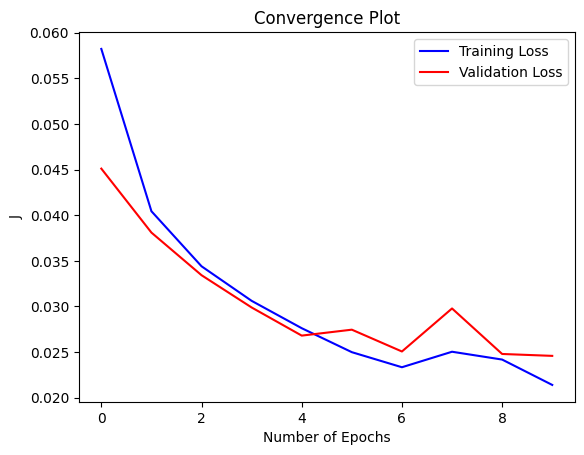

In [12]:
plt.plot(training_history, 'b', label = 'Training Loss')
plt.plot(validation_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Convergence Plot')
plt.show()

### *d. Testing (Sample Test Cases)*

In [51]:
images, targets = next(iter(test_dataloader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

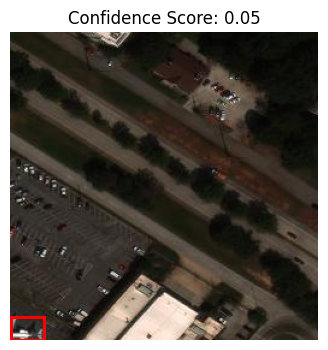

In [52]:
fig, axs = plt.subplots(1, 1, figsize = (4, 4))

retinanet_model.eval()

predictions1 = retinanet_model(images[0].unsqueeze(0))

boxes = predictions1[0]['boxes']
scores = predictions1[0]['scores']
for box, score in zip(boxes, scores):
  box = box.int().tolist()
  confidence = score.item()

  img = images[0].cpu().numpy().transpose(1, 2, 0)

  # normalize the image
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)

  axs.imshow(img)
  axs.axis('off')

  boxes = targets[0]['boxes'].cpu().numpy()
  for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    axs.add_patch(rect)
    plt.title(f'Confidence Score: {confidence:.2f}')

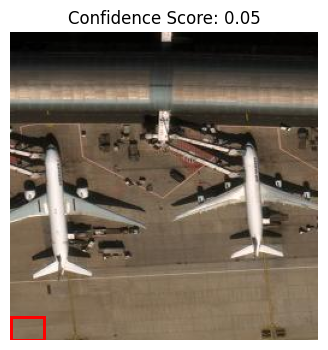

In [53]:
fig, axs = plt.subplots(1, 1, figsize = (4, 4))

retinanet_model.eval()

predictions1 = retinanet_model(images[1].unsqueeze(0))

boxes = predictions1[0]['boxes']
scores = predictions1[0]['scores']
for box, score in zip(boxes, scores):
  box = box.int().tolist()
  confidence = score.item()

  img = images[1].cpu().numpy().transpose(1, 2, 0)

  # normalize the image
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)

  axs.imshow(img)
  axs.axis('off')

  boxes = targets[0]['boxes'].cpu().numpy()
  for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    axs.add_patch(rect)
    plt.title(f'Confidence Score: {confidence:.2f}')

### *e. Testing the Network*

In [48]:
from torchvision.ops import box_iou

# Define IoU threshold for determining true positives
iou_threshold = 0.01

# Initialize variables for precision and recall computation
true_positives = 0
false_positives = 0
false_negatives = 0
total_predictions = 0
total_targets = 0
ious_all = []

with torch.no_grad():
  retinanet_model.eval()

  for data in test_dataloader:
    images, targets = data
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    predictions = retinanet_model(images)
    # Iterate through each prediction and ground truth target
    for prediction, target in zip(predictions, targets):
        # Convert predicted and ground truth bounding boxes to numpy arrays
        pred_boxes = prediction['boxes'].cpu().numpy()
        true_boxes = target['boxes'].cpu().numpy()

        # Calculate IoU between predicted and ground truth bounding boxes
        ious = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes)).numpy()
        ious_all.extend(ious.max(axis=1))  # Store IoUs for all predictions

        # Determine true positives, false positives, and false negatives
        true_positives += (ious.max(axis=1) >= iou_threshold).sum()
        false_positives += (ious.max(axis=0) < iou_threshold).sum()
        false_negatives += (ious.max(axis=1) < iou_threshold).sum()

        # Update total predictions and targets
        total_predictions += len(pred_boxes)
        total_targets += len(true_boxes)

# Compute precision, recall, and mean average precision
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
mean_average_precision = np.mean(np.array(ious_all) >= iou_threshold)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Mean Average Precision (mAP):", mean_average_precision)

Precision: 0.9993283653692391
Recall: 0.35593780258586316
Mean Average Precision (mAP): 0.35593780258586316
